## Background

This notebook can be used to analyze the errors made by a model.

In [ ]:
!ls

## Imports

In [1]:
from Model import ModelFactory
from Utils import display, save
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from Segmenter import Segmenter
from Tesseract_TextDetector import TextDetector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import sys
import numpy
import cv2
import os
numpy.set_printoptions(threshold=sys.maxsize)
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Load Model

In [2]:
model = load_model('../models/beta.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 16)        64        
__________

In [3]:
mf = ModelFactory('betaconfig.json')

[INFO] kernelVals: [3, 3, 3, 5, 5, 5]
[INFO] trainDir: ../imgs/train
[INFO] numEpochs: 50
[INFO] testDir: ../imgs/test
[INFO] savepath: ../models/beta.h5
[INFO] mapping: {0: '#', 1: '$', 2: '(', 3: ')', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '@', 15: 'A', 16: 'B', 17: 'C', 18: 'D', 19: 'E', 20: 'F', 21: 'G', 22: 'H', 23: 'I', 24: 'J', 25: 'K', 26: 'L', 27: 'M', 28: 'N', 29: 'O', 30: 'P', 31: 'Q', 32: 'R', 33: 'S', 34: 'T', 35: 'U', 36: 'V', 37: 'W', 38: 'X', 39: 'Y', 40: 'Z', 41: 'a', 42: 'b', 43: 'd', 44: 'e', 45: 'f', 46: 'g', 47: 'h', 48: 'n', 49: 'q', 50: 'r', 51: 'slash', 52: 't'}
[INFO] numFilters: [8, 16, 32, 64, 128, 256]
[INFO] imgSize: (28, 28, 1)
[INFO] validDir: ../imgs/validation
[INFO] minConfidence: 0.5
[INFO] dropoutRatio: 0.0
[INFO] learningRate: 0.01
[INFO] modelName: beta
[INFO] numClasses: 53
[INFO] batchSize: 32
[INFO] logpath: ../logs/Time_1551_Date_18-07Model_beta
[INFO] strideVals: [1, 1, 1, 1, 1, 1]
[INFO] poolVa

## Load Data

### Define Generator

In [42]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [43]:
valid_generator = valid_datagen.flow_from_directory('../imgs/validation', 
                                                    target_size = (28, 28),
                                                    batch_size= 1, 
                                                    color_mode='grayscale',
                                                    class_mode='categorical', 
                                                    shuffle=False)

Found 12163 images belonging to 53 classes.


### Display Some Data

In [ ]:
img, y = valid_generator.next()
display(img)

## Evaluate Model

### Get Overall Accuracy

In [ ]:
model.metrics_names

In [ ]:
loss, acc = model.evaluate_generator(valid_generator, steps=len(valid_generator), verbose=1)
print('Loss: ', loss)
print('Accuracy: ', acc)

In [ ]:
print(mf.mapping)

### Get Class Predictions

In [44]:
pred = model.predict_generator(valid_generator, steps=len(valid_generator), verbose=1)
np.save('modified_predictions.npy', pred)

12163/12163 [==============================] - 127s 10ms/step


In [59]:
pred = np.load('modified_predictions.npy')

In [60]:
cls_pred = [ mf.mapping[x] for x in np.argmax(pred, axis=1)]
print(len(cls_pred))

12163


### Get Class Labels

In [61]:
i = 0
cls_true = [mf.mapping[x] for x in valid_generator.classes]
print(len(cls_true))

12163


In [62]:
from sklearn.metrics import accuracy_score, classification_report 
print(accuracy_score(cls_true, cls_pred))

0.8853901175696786


In [54]:
cr = classification_report(cls_true, cls_pred)
print(cr)

              precision    recall  f1-score   support

           #       0.99      1.00      1.00       240
           $       0.99      1.00      1.00       240
           (       0.93      0.87      0.90        31
           )       0.97      1.00      0.98        32
           0       0.64      0.71      0.67       240
           1       0.51      0.74      0.61       245
           2       0.86      0.86      0.86       245
           3       0.96      0.96      0.96       240
           4       0.93      0.89      0.91       240
           5       0.90      0.92      0.91       240
           6       0.93      0.90      0.91       240
           7       0.99      0.97      0.98       240
           8       0.92      0.93      0.93       250
           9       0.70      0.84      0.76       240
           @       1.00      0.97      0.99       240
           A       0.96      0.96      0.96       240
           B       0.96      0.96      0.96       240
           C       0.93    

In [ ]:
def writeCR(cr, name):
    idx = [mf.mapping[x] for x in range(53)]
    df = pd.DataFrame(data=cr, index=idx, columns=['precision', 'recall', 'f1-score', 'support'])
    #df.to_csv('../analysis/' + name + '.csv')

In [48]:
mapAmbig = {'0': 'O', 'I': '1', 'q':'9', 'L': '1', 'f': 'F'}

In [49]:
def changeLabels(cls_pred):
    cls_pred = [mapAmbig[x] if x in mapAmbig.keys() else x for x in cls_pred]
    return cls_pred

In [50]:
modified_cls_pred = changeLabels(cls_pred)

In [51]:
modified_cls_true = changeLabels(cls_true)

In [52]:
print(accuracy_score(modified_cls_true, modified_cls_pred))

0.937433199046288


In [53]:
modified_cr = classification_report(modified_cls_true, modified_cls_pred)
print(modified_cr)

              precision    recall  f1-score   support

           #       0.99      1.00      1.00       240
           $       0.99      1.00      1.00       240
           (       0.93      0.87      0.90        31
           )       0.97      1.00      0.98        32
           1       0.96      0.96      0.96       735
           2       0.86      0.86      0.86       245
           3       0.96      0.96      0.96       240
           4       0.93      0.89      0.91       240
           5       0.90      0.92      0.91       240
           6       0.93      0.90      0.91       240
           7       0.99      0.97      0.98       240
           8       0.92      0.93      0.93       250
           9       0.85      0.88      0.87       470
           @       1.00      0.97      0.99       240
           A       0.96      0.96      0.96       240
           B       0.96      0.96      0.96       240
           C       0.93      0.94      0.94       240
           D       0.89    

In [ ]:
writeCR(modified_cr, 'beta_ModifiedClassificationReport')

### Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(cls_pred, cls_true, num_classes, width=27, height=18, save=False, name=None): 
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    
    # Set plot width and height
    plt.rcParams["figure.figsize"] = [width, height]

    # Plot the confusion matrix as an image.
    plt.matshow(cm)
    
    # Get labels
    idx = [mf.mapping[x] for x in range(53)]
    
    # Make various adjustments to the plot.
    plt.colorbar()
    plt.grid()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, idx)
    plt.yticks(tick_marks, idx)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    if save:
        plt.savefig('../analysis/' + name + '.png')
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
plot_confusion_matrix(cls_pred, cls_true, 53, save=True)

**Error Classifications:**    
GT -> PRED     
(Unreasonable, Common)
- 'g' -> '8'
- 'q' -> '8'
- 'q' -> 'g'
- 'S' -> '5'
- 'g' -> 'G'

(Reasonable, Common)
- 'O' -> '0'
- 'L' -> '1'
- 'I' -> '1'
- 'G' -> '6'
- 'Z' -> '2'
- 'g' -> '9'
- 'f' -> 'F'
- 't' -> 'T'

(Unreasonable, Uncommon)
- 'a' -> '2'
- 'a' -> 'A'
- 'q' -> '2'
- 'q' -> '4'
- 'r' -> '4'
- 'r' -> '5'

In [ ]:
confusionMatrix.to_csv('ConfusionMatrix.csv')

### Compute Statistics

In [ ]:
numCorrectPerClass = np.diag(confusionMatrix)

In [ ]:
totalNumPerClass = confusionMatrix.sum(axis=0)

In [ ]:
errorContributionPerClass = (totalNumPerClass - numCorrectPerClass) * 100 / totalNumPerClass

### Visualize Errors

In [ ]:
def getCorrectImgs(cls_pred, cls_true, pred_label, true_label):
    correctIdxs = []
    for i in range(len(cls_pred)):
        if cls_true[i] == true_label and cls_pred[i] == true_label:
            correctIdxs.append(i)
            
    imgs = np.array([cv2.imread(valid_generator.filepaths[x], cv2.IMREAD_GRAYSCALE) for x in correctIdxs])  
    display(imgs[0:9], multiple=True, rows=3, cols=3)
    return imgs


In [ ]:
correctImgs = getCorrectImgs(cls_pred, cls_true, 'q', '8')

In [ ]:
preprocessedImg = mf.preprocess(correctImgs[0], show=False, minBlack=0, invert=False)
model.predict(preprocessedImg)

In [40]:
def getMisclassifiedImgs(cls_pred, cls_true, pred_label, true_label):   
    # Get all misclassified (error) indexes
    errorIdxs = []
    if pred_label == None:
        for i in range(len(cls_pred)):
            if cls_true[i] == true_label and cls_pred[i] != true_label:
                errorIdxs.append(i)
    else:
        for i in range(len(cls_pred)):
            if cls_true[i] == true_label and cls_pred[i] == pred_label:
                errorIdxs.append(i)

    print("No. of '{}' misclassified as '{}' = {}".format(true_label, pred_label ,len(errorIdxs)))
    
    errorImgpaths = [valid_generator.filepaths[x] for x in errorIdxs]
    print(errorImgpaths)
    errorImgs = np.array([cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in errorImgpaths])
    if len(errorImgs) % 2 == 0:
        rows = 2
        cols = int(len(errorImgs) / 2)
        display(errorImgs, multiple=True, rows=rows, cols=cols)
    
    else:
        for img in errorImgs:
            display(img)
        
    return errorImgs, errorImgpaths

No. of 'S' misclassified as '5' = 17
['../imgs/validation/S/EMNIST_104876.png', '../imgs/validation/S/EMNIST_108599.png', '../imgs/validation/S/EMNIST_108637.png', '../imgs/validation/S/EMNIST_11105.png', '../imgs/validation/S/EMNIST_2430.png', '../imgs/validation/S/EMNIST_30802.png', '../imgs/validation/S/EMNIST_31383.png', '../imgs/validation/S/EMNIST_36246.png', '../imgs/validation/S/EMNIST_3896.png', '../imgs/validation/S/EMNIST_49838.png', '../imgs/validation/S/EMNIST_51524.png', '../imgs/validation/S/EMNIST_53692.png', '../imgs/validation/S/EMNIST_5492.png', '../imgs/validation/S/EMNIST_55714.png', '../imgs/validation/S/EMNIST_58662.png', '../imgs/validation/S/EMNIST_61566.png', '../imgs/validation/S/EMNIST_8042.png']


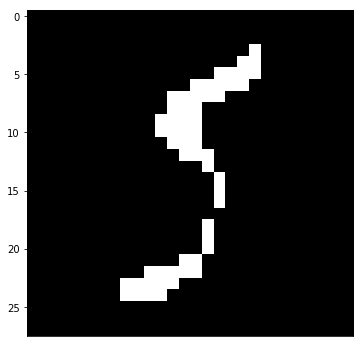

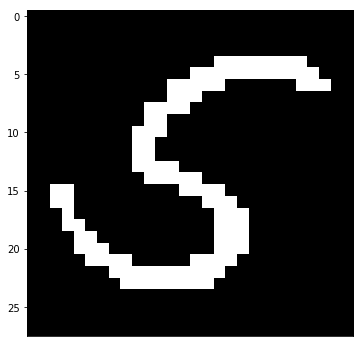

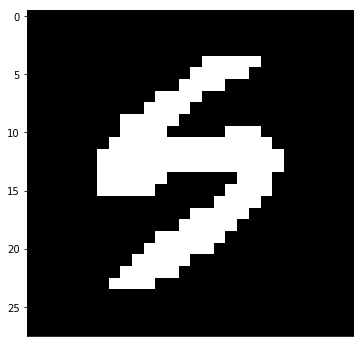

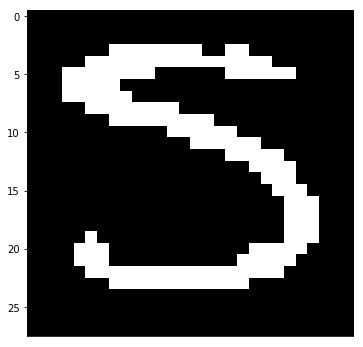

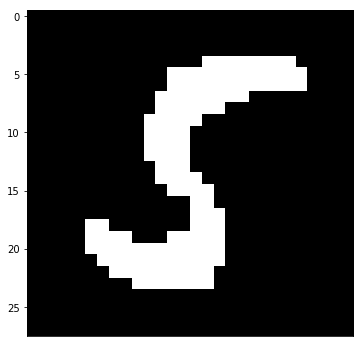

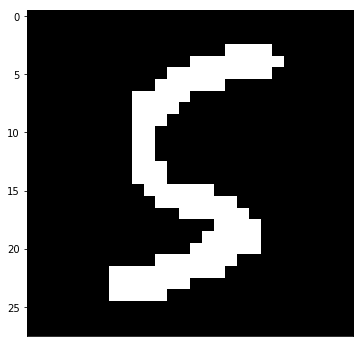

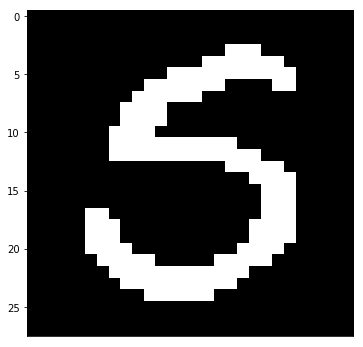

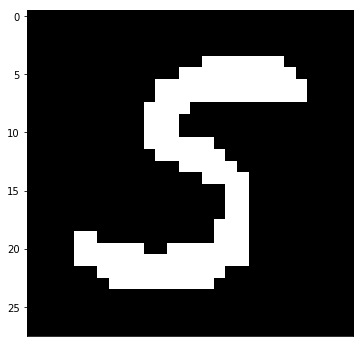

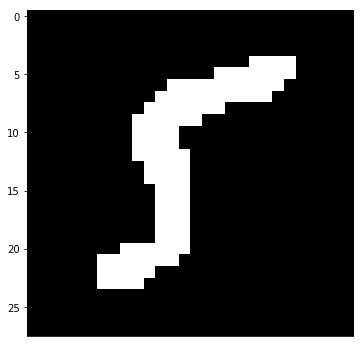

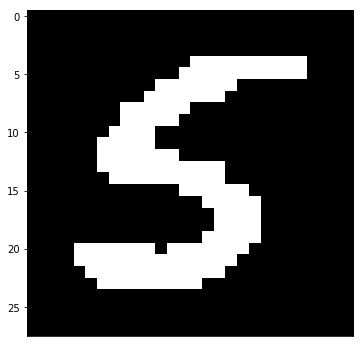

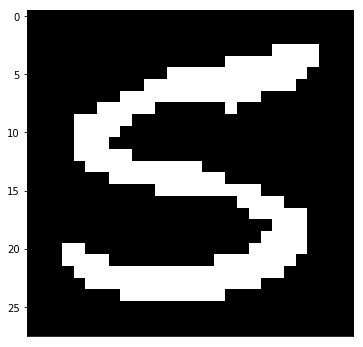

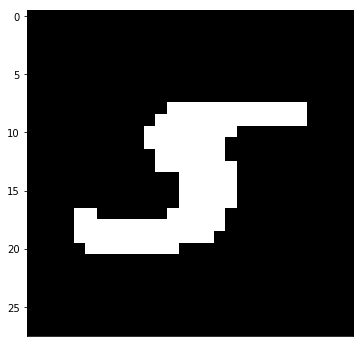

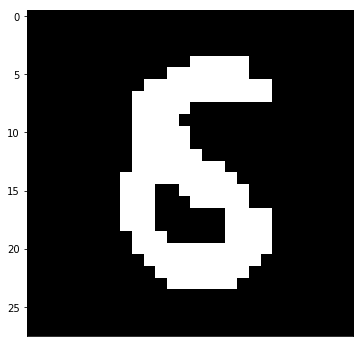

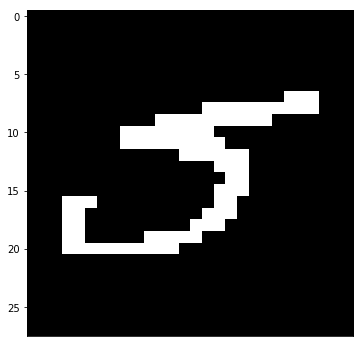

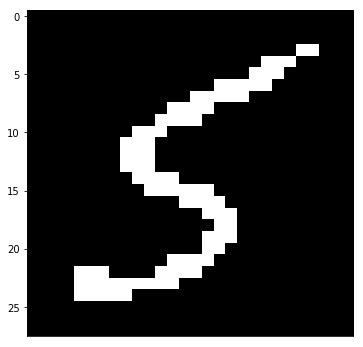

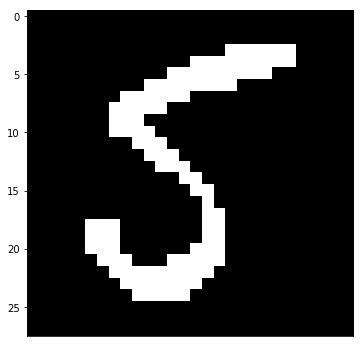

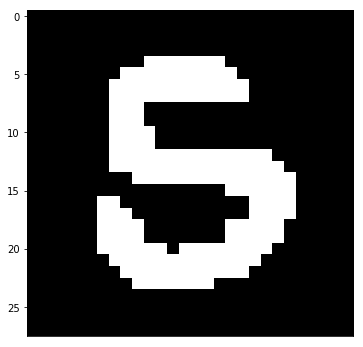

In [41]:
errorImgs, errorImgpaths = getMisclassifiedImgs(cls_pred, cls_true, '8', 'q')

### Data Cleaning

In [36]:
import os
def countFiles(folder):
    count = 0
    for root, _, files in os.walk(folder):
        for file in files:
            if '.png' not in file:
                continue
            count += 1
    print('No. of files in {}: {}'.format(folder, count))
    return count

In [27]:
countFiles('../imgs/validation/q')

No. of files in ../imgs/validation/q: 240


In [33]:
import shutil
def moveFiles(src, dst, imgPaths):
    initCountSrc = countFiles(src)
    initCountDst = countFiles(dst)
    
    for i in imgPaths:
        print('Moving file: {} to {}'.format(i, dst))
        shutil.move(i, dst)
            
    finalCountSrc = countFiles(src)
    finalCountDst = countFiles(dst)
    
    assert initCountSrc - finalCountSrc == finalCountDst - initCountDst == len(imgPaths)
    assert os.path.isfile(os.path.join(dst, imgPaths[0]))

In [34]:
moveFiles('../imgs/validation/q', '../imgs/validation/8', errorImgpaths)

No. of files in ../imgs/validation/q: 240
No. of files in ../imgs/validation/8: 240
Moving file: ../imgs/validation/q/EMNIST_104952.png to ../imgs/validation/8
Moving file: ../imgs/validation/q/EMNIST_29502.png to ../imgs/validation/8
Moving file: ../imgs/validation/q/EMNIST_3490.png to ../imgs/validation/8
Moving file: ../imgs/validation/q/EMNIST_36923.png to ../imgs/validation/8
Moving file: ../imgs/validation/q/EMNIST_41258.png to ../imgs/validation/8
Moving file: ../imgs/validation/q/EMNIST_50162.png to ../imgs/validation/8
Moving file: ../imgs/validation/q/EMNIST_81250.png to ../imgs/validation/8
Moving file: ../imgs/validation/q/EMNIST_83081.png to ../imgs/validation/8
Moving file: ../imgs/validation/q/EMNIST_92476.png to ../imgs/validation/8
Moving file: ../imgs/validation/q/EMNIST_92809.png to ../imgs/validation/8
No. of files in ../imgs/validation/q: 230
No. of files in ../imgs/validation/8: 250


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

### View Saliency Maps

In [ ]:
model.summary()

In [ ]:
!pip3 show keras_vis

In [ ]:
from vis.visualization import visualize_cam, visualize_saliency, overlay

In [ ]:
print(mf.mapping)

In [ ]:
import matplotlib.cm as cm

In [ ]:
layer_idx = -1
penultimate_layer_idx = -5
x_test = [mf.preprocess(x, show=False, minBlack=0, invert=False) for x in errorImgs]
print(x_test[0].shape)

In [ ]:
for idx in range(len(x_test)):
    if idx == 5:
        break
    grads = visualize_saliency(model, layer_idx, filter_indices=4, 
                               seed_input=x_test[idx], backprop_modifier='guided')

    f, ax = plt.subplots(1, 2)
    ax[0].imshow(errorImgs[idx])
    ax[1].imshow(grads, cmap='jet')

In [ ]:
for idx in range(len(x_test)):
    if idx == 1:
        break
    f, ax = plt.subplots(1, 4)
    ax[0].imshow(correctImgs[idx])

    for i, modifier in enumerate([None, 'guided', 'relu']): 
        
        grads = visualize_cam(model, layer_idx, 
                              filter_indices=4, 
                              
                              seed_input=x_test[idx],
                              backprop_modifier= modifier)
        if modifier is None:
            modifier = 'vanilla'

        ax[i+1].set_title(modifier)
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
#         import pdb
#         pdb.set_trace()
#         src = np.expand_dims(correctImgs[idx], axis=-1)
#         print(jet_heatmap.shape)
#         print(src.shape)
        ax[i+1].imshow(overlay(jet_heatmap, cv2.cvtColor(np.expand_dims(correctImgs[idx], axis=-1), cv2.COLOR_GRAY2BGR)))

    '''
    f, ax = plt.subplots(1,2)
    ax[0].imshow(correctImgs[idx])
    ax[1].imshow(grads, cmap='jet')
    '''

In [ ]:
correctImgs[0].shape

In [ ]:
help(visualize_cam)

In [ ]:
from keras import activations
from vis.utils import utils
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)